# Density, cities and other time-invariant data
This notebook contains many snippets to generate the smaller datasets and variables, those that do not need to be regenerated often. 

When making this available to the private repo, I edited it minimally to add documentation, but some codes might be broken. Also, all absolute paths where removed. It assumes that the GPW raw data (tiff) was downloaded to a "GPW" folder in the data dir.

In [2]:
from pathlib import Path
import warnings

from dask.distributed import Client

import rioxarray
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import xesmf as xe

from cartopy import crs
from cartopy import feature as cfeat
from cartopy.io.img_tiles import Stamen
from matplotlib import pyplot as plt
import matplotlib as mpl

datadir = Path('/datadir/') # where all data for this project is written
era5dir = Path('/era5dir/') # Where era5-land data is

# Génération des masques
Some invariant maps, needed for the dashboard : sftlf, region of interest(roi), population density.


## Fraction terre-mer de ERA5-Land

In [ ]:
ref = xr.open_dataset(era5dir / 'era5-land_tas.nc')
rawmask = xr.open_dataset('/path/to/lsm_1279l4_0.1x0.1.grb_v4_unpack.nc')
rawmask['longitude'] = rawmask.longitude.where(rawmask.longitude < 180, np.round(rawmask.longitude - 360, 1))
sftlf = rawmask.lsm.sel(longitude=ref.lon, latitude=ref.lat).squeeze('time', drop=True)
sftlf = sftlf.drop(['longitude', 'latitude'])
sftlf.attrs.update(
    units='1', 
    standard_name='land_area_fraction',
    long_name='Land-sea fraction'
)
sftlf.lon.attrs.update(standard_name='longitude', units='degrees_east', axis='X')
sftlf.lat.attrs.update(standard_name='latitude', units='degrees_north', axis='Y')
sftlf

## Masque booléan du rectangle d'intérêt

In [ ]:
# Mask of region of interest
mask = sftlf.where(
    (sftlf.lon < -48) & (sftlf.lon > -170) & (sftlf.lat > 22) & (sftlf.lat < 85)
).notnull().rename('roi')
mask.attrs.update(
    units='1',
    long_name='Region of interest mask'
)
mask

## Densité de la population.

Ici, on ne peut utiliser la densité de GPW directement car elle est déjà ajustée pour la proportion du pixel qui est sur la terre : ça chierait solide dans l'aggrégation avec xESMF. Donc, on prend le produit du nombre d'habitants, puis on le divise par l'aire _totale_ des carrés de grille (land area + water area). Ici, les données sont "NaN" sur les points d'océans.

On change de grille avec xESMF, méthode conservative. Les deux grilles étant immenses, on ne peut faire le changement en un appel, la mémoire vive s'en trouve remplie. On itère sur des sous-zones de 100x100 de la grille d'ERA5. Les données GPW (la densité brute recalculée) sont coupées à chaque zone plus une bordure. Les poids de transfert sont écrits sur disque pour un recalcul rapide.

Finalement, une densité ajustée pour la proportion terre-merre est calculée mais avec le masque terre-mer de ERA5-Land (et non celui de GPW).

In [2]:
# open gpw data
def read_gpw(what='count', year=2000, bbox=[-180, -10, 10, 90]):
    """Read the GPW data downloaded to the project directory.
    
    Parameters
    ----------
    what: str
      Which dataset to read in.
    year: int
      If what is 'count' or 'density', the year, in 2000, 05, 10, 15, 20.
    bbox: seq of 4 int
      Min, max lon, lat of bounding box.
    """
    gpw_names = {
        'count': f'gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_{year:04d}_30_sec.tif',
        'density': f'gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_{year:04d}_30_sec.tif',
        'context': 'gpw_v4_data_quality_indicators_rev11_context_30_sec.tif',
        'meanadmarea' : 'gpw_v4_data_quality_indicators_rev11_mean_adminunitarea_30_sec.tif',
        'watermask': 'gpw_v4_data_quality_indicators_rev11_watermask_30_sec.tif',
        'landarea': 'gpw_v4_land_water_area_rev11_landareakm_30_sec.tif',
        'waterarea': 'gpw_v4_land_water_area_rev11_waterareakm_30_sec.tif'
    }
    # Open with rio to have proper masking
    gpw = rioxarray.open_rasterio(datadir / 'GPW' / gpw_names[what], masked=True)
    gpw = gpw.rename(x='lon', y='lat').squeeze('band', drop=True).drop_vars('spatial_ref')

    # Very small differences (order 1e-11) exist in the coords of the different datasets
    # Also, some datasets don't have the full extent...
    crds = xr.open_dataset(datadir / 'GPW' / 'gpw_coords.nc')
    gpw = gpw.reindex(lat=crds.lat, lon=crds.lon, method='nearest')
    gpw.lat.attrs.update(units='degrees_north', long_name='latitude')
    gpw.lon.attrs.update(units='degrees_east', long_name='longitude')

    gpw = gpw.sel(lon=slice(bbox[0], bbox[1]), lat=slice(bbox[3], bbox[2])).rename(what)
    if what in ['count', 'density']:
        gpw = gpw.expand_dims(year=[year])

    # Masking is handled by the masks, 0 is the correct value for all datasets.
    gpw = gpw.fillna(0)
    return gpw

In [5]:
# Computing cell area for recalculating density
lar = read_gpw(what='landarea')  # Land area in km
war = read_gpw(what='waterarea')  # Water area in km
msk = read_gpw(what='watermask')  # 0 is only non-ocean water, 1 is partial, 2 only land and 3 ocean.
# lar and war are NaN over the ocean, this might not be needed.
area = (lar + war).where(msk < 3)
area = area.rename('areacell')
area.attrs.update(
    standard_name='cell_area',
    long_name='Cell area of non-ocean GPW cells',
    description='Cell area of the GPW grid, masked on the ocean.',
    units='km2'
)
#area.to_netcdf(datadir / 'GPW' / 'gpw_cell_area.nc')

In [6]:
import ESMF

def get_cell_area(da, gridname, R=6278):
    grid, shape, names = xe.frontend.ds_to_ESMFgrid(da.rename('da').to_dataset(), need_bounds=True)
    field = ESMF.Field(grid, name='areafield')
    field.get_area()

    cellarea = da.copy(data=field.data.T * R**2).rename('areacell')
    cellarea.attrs.update(
        standard_name='cell_area',
        long_name=f'Cell area of {gridname}',
        description=f'Cell area of the {gridname} grid, as computed with ESMF assuming a spherical earth of radius {R} km',
        units='km2'
    )
    
    field.destroy()
    grid.destroy()
    return cellarea

In [7]:
import itertools
import multiprocessing as mp

In [ ]:
N = 1000

def _cell_area_comp(i, j, da):
    out = get_cell_area(da, 'GPW')
    print(f'{i}, {j} Done.')
    return i, j, out

pieces = []
for i, j in itertools.product(range(0, 9601, N), range(0, 20401, N)):
    pieces.append((i, j, lar.isel(lat=slice(i, i + N), lon=slice(j, j + N))))

with mp.Pool(8) as p:
    results = p.starmap(_cell_area_comp, pieces)

Is, _, _ = zip(*results)

zones = []
for curr_i in np.unique(Is):
    zones.append(
        xr.concat(
            [out for i, j, out in results if i == curr_i],
            'lon'
        )
    )
areaf = xr.concat(zones, 'lat')

In [12]:
areaf.to_dataset().to_netcdf('/exec/pbourg/ProjAnalogues/GPW/gpw_cell_area_esmf.nc')

In [8]:
areaf = xr.open_dataset('/exec/pbourg/ProjAnalogues/GPW/gpw_cell_area_esmf.nc').areacell
areaf

<xarray.DataArray 'areacell' (lat: 9600, lon: 20400)>
[195840000 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 90.0 89.99 89.98 89.97 ... 10.03 10.02 10.01 10.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... -10.02 -10.01 -10.0
Attributes:
    RepresentationType:  ATHEMATIC
    standard_name:       cell_area
    long_name:           Cell area of GPW
    description:         Cell area of the GPW grid, as computed with ESMF ass...
    units:               km2

In [10]:
sftlf_gpw = lar / areaf
sftlf_gpw = sftlf_gpw.where(np.isfinite(sftlf_gpw), 0).rename('sftlf')
sftlf_gpw.attrs.update(
    units='1', 
    standard_name='land_area_fraction',
    long_name='Land area fraction'
)
sftlf_gpw.to_dataset().to_netcdf(datadir / 'GPW' / 'gpw_sftlf.nc')

In [9]:
sftlf_gpw = xr.open_dataset(datadir / 'GPW' / 'gpw_sftlf.nc')

In [10]:
area_era5l = get_cell_area(sftlf, 'ERA5-land')

In [11]:
tgt = area_era5l
src = read_gpw(year=2000, what='count').fillna(0)
N = 100

In [12]:
def _create_weights(i, j):
    latslc = slice(i, i + N) if i != 600 else slice(600, None)
    lonslc = slice(j, j + N) if j != 1600 else slice(1600, None)
    tgt_sub = tgt.isel(lat=latslc, lon=lonslc)
    
    # Subset of GPW but with border of 0.2° (~24 pts, should be ok!)
    src_sub = src.sel(
        lat=slice(tgt_sub.lat[0] + 0.2, tgt_sub.lat[-1] - 0.2),
        lon=slice(tgt_sub.lon[0] - 0.2, tgt_sub.lon[-1] + 0.2)
    )
    
    # Sum of 0 means no pop, no need to regrid!
    if src_sub.sum() == 0:
        print(f'{i}, {j} This slice is unhabited.')
    else:
        regridder = xe.Regridder(src_sub.to_dataset(), tgt_sub.to_dataset(), 'conservative', unmapped_to_nan=True)
        regridder.to_netcdf(datadir / 'GPW' / f'regrid_i{i}_j{j}.nc')
        print(f'{i}, {j} Created weigths.')

with mp.Pool(8) as p:
    p.starmap(_create_weights, itertools.product(range(0, 601, N), range(0, 1601, N)))

0, 1600 This slice is unhabited.0, 400 This slice is unhabited.

0, 0 This slice is unhabited.
0, 500 This slice is unhabited.0, 100 This slice is unhabited.

0, 600 This slice is unhabited.0, 200 This slice is unhabited.

0, 300 This slice is unhabited.
0, 800 Created weigths.
100, 0 Created weigths.
0, 700 Created weigths.
100, 700 Created weigths.
100, 1100 Created weigths.
100, 1500 Created weigths.
0, 1200 Created weigths.
0, 1300 This slice is unhabited.
0, 1400 This slice is unhabited.
0, 1500 This slice is unhabited.
100, 300 Created weigths.
100, 1600 Created weigths.
0, 900 Created weigths.
100, 800 Created weigths.
100, 100 Created weigths.
100, 1200 Created weigths.
100, 1300 This slice is unhabited.
200, 600 Created weigths.
200, 200 Created weigths.
100, 400 Created weigths.
200, 0 Created weigths.
100, 900 Created weigths.
0, 1000 Created weigths.
200, 700 Created weigths.
100, 1400 Created weigths.
100, 200 Created weigths.
200, 1400 This slice is unhabited.
100, 500 Cr

In [24]:
def _regrid_landarea(i, j):
    latslc = slice(i, i + N) if i != 600 else slice(600, None)
    lonslc = slice(j, j + N) if j != 1600 else slice(1600, None)

    # Subset of ERA5-Land cell area
    asub = area_era5l.isel(lat=latslc, lon=lonslc)
    A = asub.rename(lon='lon_out', lat='lat_out')

    wfile = datadir / 'GPW' / f'regrid_i{i}_j{j}.nc'
    if wfile.is_file():
        # Subset of GPW but with border of 0.2° (~24 pts, should be ok!)
        lsub = lar.sel(
            lat=slice(asub.lat[0] + 0.2, asub.lat[-1] - 0.2),
            lon=slice(asub.lon[0] - 0.2, asub.lon[-1] + 0.2)
        )

        aisub = areaf.sel(
            lat=slice(asub.lat[0] + 0.2, asub.lat[-1] - 0.2),
            lon=slice(asub.lon[0] - 0.2, asub.lon[-1] + 0.2)
        )

        L = lsub.rename(lon='lon_in', lat='lat_in')
        Ai = aisub.rename(lon='lon_in', lat='lat_in')

        weights = xe.smm.read_weights(wfile, lsub.size, asub.size)
        w = xr.DataArray(
            weights.data.reshape(asub.shape + lsub.shape),
            dims=('lat_out', 'lon_out', 'lat_in', 'lon_in'),
            coords={**A.coords, **L.coords}
        )

        li = w * A * L / Ai
        landarea = A.copy(data=li.sum(['lat_in', 'lon_in']).data.todense()).rename('landarea')
    else:
        landarea = (A * 0).rename('landarea')
    landarea.attrs.update(
        long_name='Land area within the ERA5-land pixel, as given by GPW.',
        units='km2'
    )
    print(i, j, 'Done')
    return i, j, landarea

with mp.Pool(1) as p:
    results = p.starmap(_regrid_landarea, itertools.product(range(0, 601, N), range(0, 1601, N)))

Is, _, _ = zip(*results)

0 0 Done
0 100 Done
0 200 Done
0 300 Done
0 400 Done
0 500 Done
0 600 Done
0 700 Done
0 800 Done
0 900 Done
0 1000 Done
0 1100 Done
0 1200 Done
0 1300 Done
0 1400 Done
0 1500 Done
0 1600 Done
100 0 Done
100 100 Done
100 200 Done
100 300 Done
100 400 Done
100 500 Done
100 600 Done
100 700 Done
100 800 Done
100 900 Done
100 1000 Done
100 1100 Done
100 1200 Done
100 1300 Done
100 1400 Done
100 1500 Done
100 1600 Done
200 0 Done
200 100 Done
200 200 Done
200 300 Done
200 400 Done
200 500 Done
200 600 Done
200 700 Done
200 800 Done
200 900 Done
200 1000 Done
200 1100 Done
200 1200 Done
200 1300 Done
200 1400 Done
200 1500 Done
200 1600 Done
300 0 Done
300 100 Done
300 200 Done
300 300 Done
300 400 Done
300 500 Done
300 600 Done
300 700 Done
300 800 Done
300 900 Done
300 1000 Done
300 1100 Done
300 1200 Done
300 1300 Done
300 1400 Done
300 1500 Done
300 1600 Done
400 0 Done
400 100 Done
400 200 Done
400 300 Done
400 400 Done
400 500 Done
400 600 Done
400 700 Done
400 800 Done
400 900 Done
40

In [29]:
zones = []
for curr_i in np.unique(Is):
    zones.append(
        xr.concat(
            [out for i, j, out in results if i == curr_i],
            'lon_out'
        )
    )
landarea = xr.concat(zones, 'lat_out').rename(lat_out='lat', lon_out='lon')

In [13]:
def _regrid_density(yr, i, j, src):
    latslc = slice(i, i + N) if i != 600 else slice(600, None)
    lonslc = slice(j, j + N) if j != 1600 else slice(1600, None)

     # Subset of ERA5-Land grid
    asub = area_era5l.isel(lat=latslc, lon=lonslc)

    wfile = datadir / 'GPW' / f'regrid_i{i}_j{j}.nc'  # weights file name
    if not wfile.is_file():
        out = asub * 0
        out = out.rename('density').expand_dims(year=[year])
        out.attrs.update(src.attrs)
        return yr, i, j, out

    # Subset of GPW but with border of 0.2° (~24 pts, should be ok!)
    gsub = src.sel(
        lat=slice(asub.lat[0] + 0.2, asub.lat[-1] - 0.2),
        lon=slice(asub.lon[0] - 0.2, asub.lon[-1] + 0.2)
    )
    
    regridder = xe.Regridder(
        gsub.to_dataset(), asub.to_dataset(), 'conservative', weights=wfile, unmapped_to_nan=True
    )
            
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        greg = regridder(gsub)
    print(yr, i, j, 'Done')
    del regridder
    return yr, i, j, greg

outs = []
for year in range(2000, 2021, 5):
    src = (read_gpw(year=year, what='count') / areaf).fillna(0).rename('density')
    for i, j in itertools.product(range(0, 601, N), range(0, 1601, N)):
        outs.append(_regrid_density(year, i, j, src))
    del src

2000 0 700 Done
2000 0 800 Done
2000 0 900 Done
2000 0 1000 Done
2000 0 1100 Done
2000 0 1200 Done
2000 100 0 Done
2000 100 100 Done
2000 100 200 Done
2000 100 300 Done
2000 100 400 Done
2000 100 500 Done
2000 100 600 Done
2000 100 700 Done
2000 100 800 Done
2000 100 900 Done
2000 100 1000 Done
2000 100 1100 Done
2000 100 1200 Done
2000 100 1400 Done
2000 100 1500 Done
2000 100 1600 Done
2000 200 0 Done
2000 200 100 Done
2000 200 200 Done
2000 200 300 Done
2000 200 400 Done
2000 200 500 Done
2000 200 600 Done
2000 200 700 Done
2000 200 800 Done
2000 200 900 Done
2000 200 1000 Done
2000 200 1100 Done
2000 200 1200 Done
2000 200 1300 Done
2000 200 1500 Done
2000 300 0 Done
2000 300 100 Done
2000 300 400 Done
2000 300 500 Done
2000 300 600 Done
2000 300 700 Done
2000 300 800 Done
2000 300 900 Done
2000 300 1000 Done
2000 300 1100 Done
2000 300 1200 Done
2000 400 500 Done
2000 400 600 Done
2000 400 700 Done
2000 400 800 Done
2000 400 900 Done
2000 400 1000 Done
2000 400 1100 Done
2000 400 

In [14]:
years = []
for curr_y in [2000, 2005, 2010, 2015, 2020]:
    zones = []
    for curr_i in range(0, 601, N):
        zones.append(
            xr.concat(
                [out[-1]
                 for out in outs
                 if isinstance(out, tuple) and out[1] == curr_i and out[0] == curr_y],
                'lon'
            )
        )
    years.append(xr.concat(zones, 'lat'))
# Yes! finally : concat all years.
density = xr.concat(years, 'year')

In [15]:
del outs
del zones
del years

In [31]:
sftlf_gpw_era5l = landarea / area_era5l
adj_dens = density / sftlf_gpw_era5l
adj_dens = adj_dens.where(np.isfinite(adj_dens), 0)

In [35]:
# Put everything in a dataset!
masks = xr.Dataset(
    data_vars={
        'dens_adj': adj_dens,
        'dens' : density,
        'roi': mask,
        'sftlf_era5': sftlf,
        'sftlf_gpw': sftlf_gpw_era5l,
        'cellarea': area_era5l,
        'data_mask': ref.tas.isel(time=1000).notnull()
    }
)
masks.dens_adj.attrs.update(
    long_name='Population density (land only)',
    description= (
        "Population density adjusted for land area fraction.\n"
        "Population count is taken from UN WPP-adjusted population count (GPW v4.11)"
        "on the 30 arc-sec grid. This was regridded using"
        "a conservative method to the ERA5-Land grid and then divided by the land area fraction"
        "in order to the give the population density of the land fraction of the grid cell only. "
        "The land area is taken from GPW regridded conservatively to the ERA5-land grid and divided "
        "by the cell area to give the land area fraction - sftlf_gpw."
    ),
    units='km-2',
    source='https://sedac.ciesin.columbia.edu/data/collection/gpw-v4',
    comments=(
        'Made using the following Gridded Population of the World, Version 4 (GPWv4) Revision 11 Data Sets:\n'
        'UN WPP-Adjusted Population Count, Data Quality Indicators: Water mask and Land and Water Area'
    )
)
masks.dens.attrs.update(
    long_name='Population density',
    description=(
        "Population density unadjusted for land area fraction.\n"
        "Population count is taken from UN WPP-adjusted population count (GPW v4.11)"
        "on the 30 arc-sec grid. This was regridded using"
        "a conservative method to the ERA5-Land grid."
    ),
    units='km-2',
    source='https://sedac.ciesin.columbia.edu/data/collection/gpw-v4',
    comments=(
        'Made using the following Gridded Population of the World, Version 4 (GPWv4) Revision 11 Data Sets:\n'
        'UN WPP-Adjusted Population Count, Data Quality Indicators: Water mask and Land and Water Area'
    )
)
masks.roi.attrs.update(
    long_name='Region of interest',
    description='Rectangle box mask True for the region of interest (mainland US and CAN).'
)
masks.sftlf_era5.attrs.update(
    long_name='Land area fraction of ERA5-land',
    description='Fraction of the grid cell covered by land, the rest is water : ocean, river or lake.',
    units='1',
    source='https://www.ecmwf.int/en/era5-land',
    license='Generated using Copernicus Climate Change Service information 2021'
)
masks.sftlf_gpw.attrs.update(
    long_name='Land area fraction of GPW',
    description=(
        "Fraction of the grid cell covered by land, the rest is water : ocean, river or lake. "
        "Obtained by regridding the land area of GPW and dividing by the grid cell area."
    ),
    units='1',
    source='https://sedac.ciesin.columbia.edu/data/collection/gpw-v4',
)
masks.attrs.update(
    title='Masques et champs fixes utiles pour le projet d\'Analogues Spatiaux.',
    author='Pascal Bourgault <bourgault.pascal@ouranos.ca>',   
)

masks.to_zarr(datadir / 'masques.zarr')

In [47]:
# Add to masks
masks = xr.open_zarr(datadir / 'masques.zarr')
masks = masks.assign(datamask=ref.tas.isel(time=1000, drop=True).notnull())
masks.datamask.attrs.update(
    long_name='Binary land mask of ERA5-land',
    description='True where ERA5-land has data.',
    units='',
    source='https://www.ecmwf.int/en/era5-land',
    license='Generated using Copernicus Climate Change Service information 2021'
)
masks.drop_vars(set(masks.data_vars.keys()) - {'datamask'}).to_zarr(datadir / 'masques.zarr', mode='a')

# Données sur les villes du projet.
Reads the EXCEL given with the contract (and then updated) and saves geojson and netCDF versions.

In [4]:
city_halls = pd.read_excel(
    'geo/listes_indices_villes_ete2021.xlsx', sheet_name='city hall coord',
    header=6,index_col=None
)
city_halls.columns

Index(['Province / territory', 'City', 'Population', 'City hall Longitude',
       'City hall Latitude', 'choice explanation', 'priority',
       'Moved to densest land cell', 'City hall in ERA5-land ocean', 'Note'],
      dtype='object')

In [5]:
city_halls.columns = ['Province', 'City', 'Population', 'lon', 'lat', 'Reason', 'Priority', 'a', 'b', 'Note']
city_halls['Reason'] = city_halls['Reason'].ffill()
city_halls['Province'] = [s.strip() for s in city_halls.Province]
city_halls = city_halls[city_halls.City != 'Conception Bay South']
city_halls

,Province,City,Population,lon,lat,Reason,Priority,a,b,Note
0,Alberta,Calgary,1239220,-114.054025,51.047023,These are the four most large Population cent...,1,NaN,NaN,NaN
1,Alberta,Edmonton,932546,-113.489233,53.545841,These are the four most large Population cent...,2,N,NaN,NaN
2,Alberta,Red Deer,100418,-113.808599,52.268743,These are the four most large Population cent...,3,NaN,NaN,NaN
3,Alberta,Lethbridge,92729,-112.828916,49.694484,These are the four most large Population cent...,3,NaN,NaN,NaN
4,Alberta,Grande Prairie,63166,-118.786385,55.173633,This is the most large Population centre in No...,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
61,Nunavut,Iqaluit,7082,-68.519629,63.750624,The 5 most large population centers in Nunavut,1,NaN,NaN,NaN
62,Nunavut,Rankin Inlet,2441,-92.080250,62.813752,The 5 most large population centers in Nunavut,3,NW,X,NaN
63,Nunavut,Arviat,2318,-94.064506,61.105358,The 5 most large population centers in Nunavut,3,NaN,NaN,NaN
64,Nunavut,Baker Lake,1872,-96.057467,64.312958,The 5 most large population centers in Nunavut,3,E,NaN,NaN


In [53]:
cancities = pd.read_csv('geo/canadacities.csv')

def get_density_off(row):
    cc = cancities[(cancities.province_name == row.Province) & (cancities.city == row.City)]
    if len(cc) == 1:
        return cc.iloc[0].density
    return np.NaN

city_halls['Density_off'] = city_halls.apply(get_density_off, axis=1)

In [54]:
gpw = read_gpw(year=2020, what='density')

In [55]:
masks = xr.open_zarr(datadir / 'masques.zarr')
masks.datamask.load()
era5l = xr.open_zarr(datadir / 'indices' / 'year_era5-land_1981-2020.zarr/')

In [56]:
def get_density_gpw(row):
    return float(gpw.sel(lat=row.lat, lon=row.lon, method='nearest'))

def get_density_era5l(row):
    return float(masks.dens_adj.sel(year=2020, lat=row.lat, lon=row.lon, method='nearest'))

adjacent_cells = ([1, 0], [2, 1], [1, 2], [0, 1], [0, 0], [2, 0], [2, 2], [0, 2])

frozen = ['Mount Pearl', 'Dieppe', 'Stratford', 'Cornwall']

def get_loc_and_max_density(row):
    m = masks.datamask.sel(lon=row.lon, lat=row.lat, method='nearest')
    ilon = np.where(masks.lon == m.lon)[0].item()
    ilat = np.where(masks.lat == m.lat)[0].item()
    land = masks.datamask.isel(lon=slice(ilon - 1, ilon + 2), lat=slice(ilat - 1, ilat + 2))
    dens = masks.dens_adj.isel(lon=slice(ilon - 1, ilon + 2), lat=slice(ilat - 1, ilat + 2)).sel(year=2020).where(land).transpose('lon', 'lat').load()
    if row.City in frozen:
        imxlon = imxlat = 1
    else:
        imxlon, imxlat = np.where(dens == dens.max())
        imxlon = imxlon[0].item()
        imxlat = imxlat[0].item()
    moved = int(imxlat != 1 or imxlon != 1) + int(not m)
    dens_max = dens.isel(lon=imxlon, lat=imxlat) 
    return dens_max.item(), dens_max.lon.item(), dens_max.lat.item(), moved
    
city_halls['Density_GPW'] = city_halls.apply(get_density_gpw, axis=1)
city_halls['Density_Adj'] = city_halls.apply(get_density_era5l, axis=1)
city_halls['Density'], city_halls['lon_grid'], city_halls['lat_grid'], city_halls['moved'] = zip(*city_halls.apply(get_loc_and_max_density, axis=1))

In [57]:
from shapely.geometry import Point
import geopandas as gpd

In [58]:
def latlon_to_pt(row):
    return Point(row.lon, row.lat)

cities = gpd.GeoDataFrame(city_halls, geometry=city_halls.apply(latlon_to_pt, axis=1), crs=4326)

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [59]:
cities.to_file('geo/cities.geojson', driver='GeoJSON')

In [10]:
cities = gpd.read_file('geo/cities.geojson')

In [11]:
cities = cities.drop(columns=['geometry', 'Density_off', 'Density_Adj', 'Density_GPW', 'Note']).to_xarray()
cities = cities.rename(
    index='location', Province='province', City='city', Population='population',
    Reason='reason', Priority='priority', Density='density', lon='lon_raw', lat='lat_raw',
    lon_grid='lon', lat_grid='lat', moved='moved'
)

cities['province'] = xr.where(cities.province == 'Quebec', 'Québec', cities.province)
prov = {
    'Manitoba': 'MB',
    'Saskatchewan': 'SK',
    'Alberta': 'AB',
    'British Columbia': 'BC',
    'Nunavut': 'NU',
    'Northwest Territories': 'NT',
    'Ontario': 'ON',
    'Québec': 'QC',
    'Nova Scotia': 'NS',
    'Newfoundland and Labrador': 'NL',
    'Yukon': 'YT',
    'New Brunswick': 'NB',
    'Prince Edward Island': 'PE'
}
cities = cities.assign(prov_code=(('location',), [prov[province] for province in cities.province.values]))

cities.prov_code.attrs.update(long_name='Province postal abbreviation')
cities.population.attrs.update(long_name='Population', source='project')
cities.lon_raw.attrs.update(long_name='City hall longitude', units='degrees_east', source='project')
cities.lat_raw.attrs.update(long_name='City hall latitude', units='degrees_north', source='project')
cities.reason.attrs.update(long_name='Reason for inclusion in the list.', source='project')
cities.priority.attrs.update(long_name='City priority', description='Highest priority to lower values', source='project')
cities.moved.attrs.update(long_name='Moved flag', description='0: City hall is in densest grid point, 1: Densest grid point is adjacent, 2: City hall is in the ocean', source='era5-land')
cities.density.attrs.update(long_name='Population density on land', units='km-2', 
                            description='Highest regridded GPW density of a 3x3 square centered on the city hall.',
                            source='gpw')
cities.lon.attrs.update(long_name='Longitude', axis='X', units='degrees_east', source='era5-land',
                        description='Longitude of the densest ERA5-land data point on a 3x3 grid around the city hall.')
cities.lat.attrs.update(long_name='Latitude', axis='Y', units='degrees_north', source='era5-land',
                        description='Latitude of the densest ERA5-land data point on a 3x3 grid around the city hall.')
cities.attrs.update(
    title='Cities metadata for the Spatial Analogs project',
    title_fr='Métadonnées sur les villes du projet Analogues Spatiaux',
    contact='bourgault.pascal@ouranos.ca',
    comment='The source attribute of each variable points to the most important data source used when computing it. "project" means the data was provided by the CCSC in a spreadsheet.')
cities.to_netcdf(
    'geo/cities.nc',
    encoding={
        'priority': {'dtype': 'int32'}, 'population': {'dtype': 'int32'},
        'moved': {'dtype': 'int32'}, 'location': {'dtype': 'int32'}
    }
)

In [13]:
cities.close()

In [5]:
cities = xr.open_dataset('geo/cities.nc')
cities

<xarray.Dataset>
Dimensions:     (location: 65)
Coordinates:
  * location    (location) int32 0 1 2 3 4 5 6 7 8 ... 57 58 59 60 61 62 63 64
Data variables:
    province    (location) object ...
    city        (location) object ...
    population  (location) int32 ...
    lon_raw     (location) float64 ...
    lat_raw     (location) float64 ...
    reason      (location) object ...
    priority    (location) int32 ...
    density     (location) float64 ...
    lon         (location) float64 ...
    lat         (location) float64 ...
    moved       (location) int32 ...
    prov_code   (location) object ...
Attributes:
    title:     Cities metadata for the Spatial Analogs project
    title_fr:  Métadonnées sur les villes du projet Analogues Spatiaux
    contact:   bourgault.pascal@ouranos.ca
    comment:   The source attribute of each variable points to the most impor...

In [6]:
gdf = gpd.GeoDataFrame(
    cities.drop_vars(['lon', 'lat']).to_dataframe(),
    geometry=[Point(lon, lat) for lon, lat in zip(cities.lon.values, cities.lat.values)],
    crs=4326
)

In [13]:
gdf.to_file('geo/cities', encoding='utf-8')
gdf.to_file('geo/cities_tmp.geojson', driver='GeoJSON', encoding='utf-8')

In [8]:
a = gpd.read_file('geo/cities/cities.shp')
a.iloc[40]

location                                                     40
province                                                 Québec
city                                                   Montréal
population                                              1762976
lon_raw                                              -73.554054
lat_raw                                               45.509137
reason        The 4 most large population centers in Quebec ...
priority                                                      1
density                                             8110.818842
moved                                                         0
prov_code                                                    QC
geometry                        POINT (-73.59999847412109 45.5)
Name: 40, dtype: object

## Liste des problèmes
All "problems" with the cities selection as discussed with the CCCS in the first meeting.

In [26]:
def print_close_cities(square):
    for i, row1 in cities.iterrows():
        for j, row2 in cities.iterrows():
            if j < i:
                dx = 0.02 + abs(row1.lon_grid - row2.lon_grid) / 0.1
                dy = 0.02 + abs(row1.lat_grid - row2.lat_grid) / 0.1
                if dx < square and dy < square and not (dx < square - 2 and dy < square - 2):
                    print(f'\t{row1.City} and {row2.City}, {row1.Province}  ({dx - 0.02:.0f}, {dy - 0.02:.0f})')

In [27]:
print('The following city halls fall within an "ocean" point of ERA5-Land:')
for i, row in cities[cities.moved].iterrows():
    print(f'\t{row.City}, {row.Province}')
print()
print('The following city pairs fall within the same ERA5-Land cell:')
print_close_cities(1)
print()
print('The following city pairs fall within the same 3x3 square of ERA5-Land cells:')
print_close_cities(3)
print()
print('The following city pairs fall within the same 5x5 square of ERA5-Land cells:')
print_close_cities(5)
print()
print('The following cities have an adjusted density less than 25% of the GPW density,\n',
      ' meaning they cover only a very small portion of the ERA5-Land cell:')
for i, row in cities.iterrows():
    if row.Density_GPW > 4 * row.Density_Adj:
        print(f'\t{row.City}, {row.Province}')
print()
print('The following city halls do not fall within the most dense ERA5-Land cell of a 3x3 square:')
for i, row in cities.iterrows():
    if row.Density != row.Density_Adj:
        print(f'\t{row.City}, {row.Province}')

The following city halls fall within an "ocean" point of ERA5-Land:
	Victoria, British Columbia
	Summerside, Prince Edward Island
	Rankin Inlet, Nunavut
	Cambridge Bay, Nunavut

The following city pairs fall within the same ERA5-Land cell:
	Stratford and Charlottetown, Prince Edward Island  (0, 0)

The following city pairs fall within the same 3x3 square of ERA5-Land cells:
	Dieppe and Moncton, New Brunswick  (1, 0)
	Mount Pearl and St. John's, Newfoundland and Labrador  (1, 1)
	Mount Pearl and Conception Bay South, Newfoundland and Labrador  (2, 0)
	Glace Bay and Cape Breton - Sydney, Nova Scotia  (2, 1)
	Cornwall and Charlottetown, Prince Edward Island  (1, 0)
	Cornwall and Stratford, Prince Edward Island  (1, 0)

The following city pairs fall within the same 5x5 square of ERA5-Land cells:
	Steinbach and Winnipeg, Manitoba  (4, 4)
	Conception Bay South and St. John's, Newfoundland and Labrador  (3, 1)
	Montague and Charlottetown, Prince Edward Island  (4, 0)
	Montague and Stratford, 

In [28]:
cities

,Province,City,Population,lon,lat,Reason,Priority,Density_off,Density_GPW,Density_Adj,Density,lon_grid,lat_grid,moved,geometry
0,Alberta,Calgary,1239220,-114.054025,51.047023,These are the four most large Population cent...,1,1501.1,4729.442871,3069.497175,3069.497175,-114.099998,51.000000,False,POINT (-114.05403 51.04702)
1,Alberta,Edmonton,932546,-113.489233,53.545841,These are the four most large Population cent...,2,1360.9,2437.248291,2734.980964,2849.824597,-113.500000,53.500000,False,POINT (-113.48923 53.54584)
2,Alberta,Red Deer,100418,-113.808599,52.268743,These are the four most large Population cent...,3,958.8,1461.347656,992.616501,992.616501,-113.800003,52.299999,False,POINT (-113.80860 52.26874)
3,Alberta,Lethbridge,92729,-112.828916,49.694484,These are the four most large Population cent...,3,759.5,1778.049316,819.029377,819.029377,-112.800003,49.700001,False,POINT (-112.82892 49.69448)
4,Alberta,Grande Prairie,63166,-118.786385,55.173633,This is the most large Population centre in No...,3,475.9,1269.907837,683.310577,683.310577,-118.800003,55.200001,False,POINT (-118.78638 55.17363)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Nunavut,Iqaluit,7082,-68.519629,63.750624,The 5 most large population centers in Nunavut,1,147.4,950.277039,32.414707,614.025832,-68.500000,63.799999,False,POINT (-68.51963 63.75062)
61,Nunavut,Rankin Inlet,2441,-92.080250,62.813752,The 5 most large population centers in Nunavut,3,140.4,669.857178,147.529495,147.529495,-92.099998,62.900002,True,POINT (-92.08025 62.81375)
62,Nunavut,Arviat,2318,-94.064506,61.105358,The 5 most large population centers in Nunavut,3,20.1,692.727966,58.448741,58.448741,-94.099998,61.099998,False,POINT (-94.06451 61.10536)
63,Nunavut,Baker Lake,1872,-96.057467,64.312958,The 5 most large population centers in Nunavut,3,11.4,1.440278,1.206614,85.628601,-96.099998,64.300003,False,POINT (-96.05747 64.31296)


# Figures pour le kick-off

## How the urban mask was computed

In [64]:
bbox_mtl = [-74.35, -73.25, 45.1, 45.8]
extend_mtl = [-74.25, -73.35, 45.15, 45.75]
g_count = read_gpw(what='count', year=2015, bbox=bbox_mtl)
g_lar = read_gpw(what='landarea', bbox=bbox_mtl)
g_area = xr.open_dataset(
    datadir / 'GPW' / 'gpw_cell_area_esmf.nc'
).sel(lon=slice(*bbox_mtl[:2]), lat=slice(*bbox_mtl[2:][::-1])).areacell
era5 = xr.open_zarr(datadir / 'masques.zarr').sel(lon=slice(*bbox_mtl[:2]), lat=slice(*bbox_mtl[2:][::-1]), year=2015)

In [65]:
g_raw_dens = g_count / g_area
g_raw_dens.attrs.update(long_name='Density', units='hab / km²')

e_lar = era5.sftlf_gpw * era5.cellarea
e_lar.attrs.update(long_name='Land area', units='km²')

In [66]:
tiler = Stamen('toner-background')

In [89]:
def fig(title, da, vmax, alpha=0.8, log=False, cmap='viridis'):
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(1, 1, 1, projection=crs.AlbersEqualArea(-73.75, 45.45))
    ax.set_extent(extend_mtl, crs=crs.PlateCarree())
    ax.add_image(tiler, 10)

    if log:
        kws = {'norm': mpl.colors.LogNorm(10, vmax)}
    else:
        kws = {'vmin': 0, 'vmax': vmax}
    da.plot(
        x='lon', y='lat', ax=ax, transform=crs.PlateCarree(), 
        edgecolor='none', alpha=alpha, cmap=cmap, add_colorbar=False,
        **kws,
    )
    ax.set_title(title)
    return fig, ax

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartop

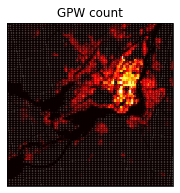

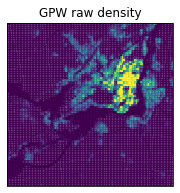

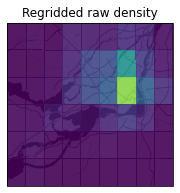

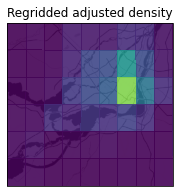

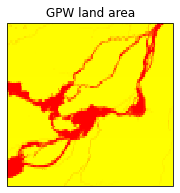

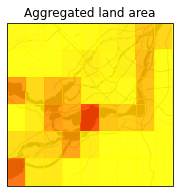

In [91]:
f, a = fig('GPW count', g_count, 1e4, cmap='hot')
f.savefig('Figures/Kick-off/gpw_count.png')

f, a = fig('GPW raw density', g_raw_dens, 1e4)
f.savefig('Figures/Kick-off/gpw_raw_dens.png')

f, a = fig('Regridded raw density', era5.dens, 1e4, alpha=0.9)
f.savefig('Figures/Kick-off/era_raW_dens.png')

f, a = fig('Regridded adjusted density', era5.dens_adj, 1e4, alpha=0.9)
f.savefig('Figures/Kick-off/era_adj_dens.png')

f, a = fig('GPW land area', g_lar, g_lar.max(), alpha=1, cmap='autumn')
f.savefig('Figures/Kick-off/gpw_landarea.png')

f, a = fig('Aggregated land area', e_lar, e_lar.max().values, alpha=0.9, cmap='autumn')
f.savefig('Figures/Kick-off/era_landarea.png')

## Problèmes de distribution spatiale

In [123]:
cities = xr.open_dataset('geo/cities.nc')
era5 = xr.open_zarr(datadir / 'masques.zarr')
tiler = Stamen('toner-background')

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


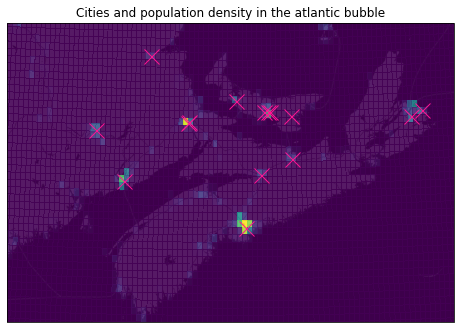

In [111]:
bbox_atl = [-68.6, -59.2, 43, 47.7]
extend_atl = [-68.3, -59.5, 43.3, 47.4]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=crs.AlbersEqualArea(-64, 43.8))
ax.set_extent(extend_atl, crs=crs.PlateCarree())
ax.add_image(tiler, 8)

era5.dens_adj.sel(lon=slice(*bbox_atl[:2]), lat=slice(*bbox_atl[2:][::-1]), year=2015).plot(
    x='lon', y='lat', ax=ax, transform=crs.PlateCarree(),
    edgecolor='none', alpha=0.9, cmap='viridis', add_colorbar=False,
    vmin=10, vmax=1000,
)
ax.plot(cities.lon_raw, cities.lat_raw, 'x', transform=crs.PlateCarree(), markersize=15, markeredgecolor="deeppink")
ax.set_title('Cities and population density in the atlantic bubble')
fig.savefig('Figures/Kick-off/distribution_atlantic.png')

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


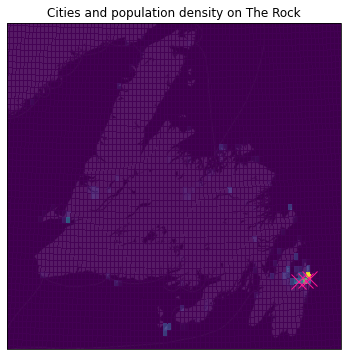

In [113]:
bbox_tnl = [-60.9, -51.1, 46., 52]
extend_tnl = [-60, -52, 46.4, 51.7]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=crs.AlbersEqualArea(-56, 48.8))
ax.set_extent(extend_tnl, crs=crs.PlateCarree())
ax.add_image(tiler, 8)

era5.dens_adj.sel(lon=slice(*bbox_tnl[:2]), lat=slice(*bbox_tnl[2:][::-1]), year=2015).plot(
    x='lon', y='lat', ax=ax, transform=crs.PlateCarree(),
    edgecolor='none', alpha=0.9, cmap='viridis', add_colorbar=False,
    vmin=10, vmax=1000,
)
ax.plot(cities.lon_raw, cities.lat_raw, 'x', transform=crs.PlateCarree(), markersize=15, markeredgecolor="deeppink")
ax.set_title('Cities and population density on The Rock')
fig.savefig('Figures/Kick-off/distribution_newfoundland.png')

## Catégories de densité

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/exec/pbourg/.conda/analog/lib/pyth

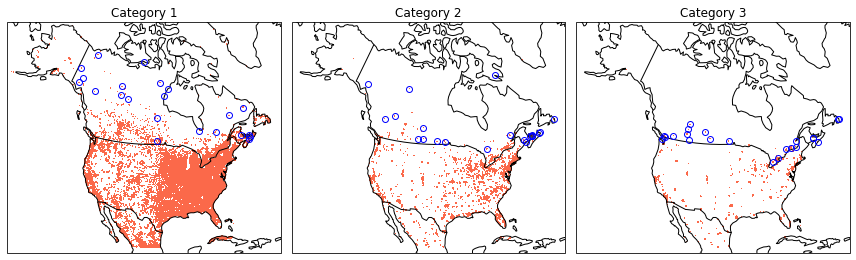

In [125]:
db = [10.5, 200, 800, np.inf]
dens = era5.dens_adj.sel(year=2015).where(era5.roi, drop=True).load()
mask = era5.datamask.where(era5.roi, drop=True).load()
fig, axs = plt.subplots(
    1, 3,
    figsize=(12, 4),
    subplot_kw={'projection': crs.LambertConformal(-100, 48)}
)
for i, ax in enumerate(axs):
    sub = cities.where((cities.density > db[i]) & (cities.density <= db[i + 1]), drop=True)
    area = mask.where((dens > db[i]) & (dens <= db[i + 1]), False)
    ax.coastlines()
    ax.add_feature(cfeat.BORDERS)
    area.where(area).plot(ax=ax, transform=crs.PlateCarree(), add_colorbar=False, cmap=plt.cm.Reds)
    ax.plot(sub.lon_raw, sub.lat_raw, 'ob', transform=crs.PlateCarree(), fillstyle='none')
    ax.set_title(f'Category {i + 1}')
    ax.set_extent([-140, -65, 20, 75], crs=crs.PlateCarree())
#axs[-1, -1].set_visible(False)
fig.tight_layout()
fig.savefig('Figures/Kick-off/Catégories_Densité_3.png')